In [1]:
fasta_file = '../data/RSV2-reduced.fasta' #dengue.fasta
date_regex = '[^s]*$'#[0-9]{2}$
out_dir = 'out'

# Topology inference

## Unrooted topology

In [2]:
import topology_inference

nj_tree = topology_inference.infer_topology_neighbor_joining(fasta_file, 'fasta', out_dir)
raxml_tree, raxml_params = topology_inference.infer_topology_raxml(fasta_file, 'fasta', out_dir, subst_model='HKY85', run_raxml=True)
raxml_params

{'alpha': 1.042979,
 'rates': {'ac': 1.0,
  'ag': 12.053774,
  'at': 1.0,
  'cg': 1.0,
  'ct': 12.053774,
  'gt': 1.0},
 'frequencies': [0.38778, 0.356966, 0.081073, 0.17418]}

## Rooting

In [3]:
rooted_tree, estimated_rate = topology_inference.root_topology(fasta_file, 'fasta', out_dir, date_regex, raxml_tree)
estimated_rate

0.0022298379517620846

In [4]:
analysis_tree = topology_inference.convert_tree(rooted_tree, 'nexus', 'newick', strip_data=True, allow_zero_branches=False, epsilon=1e-1)
analysis_tree

'out/lsd-tree.date.newick'

In [5]:
estimated_pop_size = topology_inference.estimate_pop_size(rooted_tree, 'nexus')
estimated_pop_size

20.7868

# Strict clock analysis

## Tensorflow model

### Prior

In [6]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import treeflow.coalescent
import treeflow.tree_processing

tree, taxon_names = treeflow.tree_processing.parse_newick(analysis_tree)
topology = treeflow.tree_processing.update_topology_dict(tree['topology'])
taxon_count = len(taxon_names)
sampling_times = tf.convert_to_tensor(tree['heights'][:taxon_count], dtype=tf.float32)

prior = tfd.JointDistributionNamed(dict(
    clock_rate=tfd.LogNormal(loc=0.0, scale=3.0),
    pop_size=tfd.LogNormal(loc=0.0, scale=3.0),
    tree=lambda pop_size: treeflow.coalescent.ConstantCoalescent(taxon_count, pop_size, sampling_times)
))
prior.log_prob(tree=tree, clock_rate=estimated_rate, pop_size=estimated_pop_size)

/mnt/c/chris/git/treeflow/treeflow/coalescent.py:70: UserWarning: Dummy sampling
  warnings.warn('Dummy sampling')


<tf.Tensor: shape=(), dtype=float32, numpy=-657.12683>

### Likelihood

In [7]:
import treeflow.beagle
import treeflow.substitution_model
import treeflow.sequences

subst_model = treeflow.substitution_model.HKY()
likelihood, instance = treeflow.beagle.log_prob_conditioned_branch_only(
    analysis_tree,
    fasta_file,
    subst_model,
    raxml_params['frequencies'],
    kappa=raxml_params['rates']['ag'],
    rescaling=True)

likelihood(treeflow.sequences.get_branch_lengths(treeflow.tree_processing.tree_to_tensor(tree)) * estimated_rate)

<tf.Tensor: shape=(), dtype=float32, numpy=-5492.3276>

In [8]:
import treeflow.tree_processing
wrapped_likelihood = lambda z: likelihood(treeflow.sequences.get_branch_lengths(z['tree']) * tf.expand_dims(z['clock_rate'], -1))
log_prob = lambda **z: (prior.log_prob(z) + wrapped_likelihood(z))
log_prob(tree=treeflow.tree_processing.tree_to_tensor(tree), clock_rate=estimated_rate, pop_size=estimated_pop_size)

<tf.Tensor: shape=(), dtype=float32, numpy=-6149.4546>

## Variational approximation

In [9]:
import treeflow.model

approx_name = 'q'

def rebuild_approx():
    prior_approx_dict = treeflow.model.construct_prior_approximation(prior, approx_name=approx_name, init_mode=dict(
        clock_rate=tf.convert_to_tensor(estimated_rate),
        pop_size=tf.convert_to_tensor(estimated_pop_size)
    ))
    tree_approx = treeflow.model.construct_tree_approximation(analysis_tree, approx_name)
    return tfd.JointDistributionNamed(dict(tree=tree_approx, **prior_approx_dict))
mean_field = rebuild_approx()
init_approx_sample = mean_field.sample()
log_prob(**init_approx_sample), mean_field.log_prob(init_approx_sample), [(var.name, var.shape) for var in mean_field.trainable_variables]

(<tf.Tensor: shape=(), dtype=float32, numpy=-7692.8545>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-22.794344>,
 [('q_tree_loc:0', TensorShape([125])),
  ('q_tree_scale:0', TensorShape([125])),
  ('q_pop_size_loc:0', TensorShape([])),
  ('q_pop_size_scale:0', TensorShape([])),
  ('q_clock_rate_loc:0', TensorShape([])),
  ('q_clock_rate_scale:0', TensorShape([]))])

## Model fitting

We use `tf.summary` so we can monitor model fitting with Tensorboard.

In [14]:
with tf.GradientTape(persistent=True) as t:
    for var in mean_field.trainable_variables:
        t.watch(var)
var_names = [var.name for var in t.watched_variables()]
tree_loc_index = var_names.index('q_tree_loc:0')
tree_scale_index = var_names.index('q_tree_scale:0')

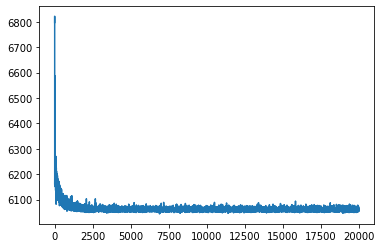

In [15]:
import matplotlib.pyplot as plt
import datetime
import pathlib
import os

run_id = datetime.datetime.now().strftime('run %Y-%m-%d %H:%M:%S')
log_dir = str(pathlib.Path('out') / 'tensorflow-logs' / run_id)
os.mkdir(log_dir)
writer = tf.summary.create_file_writer(log_dir, flush_millis=100)

def trace_fn(traceable_quantities):
    with writer.as_default():
        tf.summary.scalar('loss', tf.reduce_sum(traceable_quantities.loss), step=traceable_quantities.step)
        tf.summary.scalar('root_loc', traceable_quantities.parameters[tree_loc_index][-1], step=traceable_quantities.step)
        tf.summary.scalar('root_scale', traceable_quantities.parameters[tree_scale_index][-1], step=traceable_quantities.step)
    return traceable_quantities.loss, traceable_quantities.parameters

mean_field = rebuild_approx()
optimizer = tf.optimizers.SGD(learning_rate=0.001)
res = tfp.vi.fit_surrogate_posterior(log_prob,
                                     mean_field,
                                     optimizer,
                                     20000,
                                     trace_fn=trace_fn,
                                     trainable_variables=mean_field.trainable_variables)

plt.plot(res[0].numpy())

### Check convergence

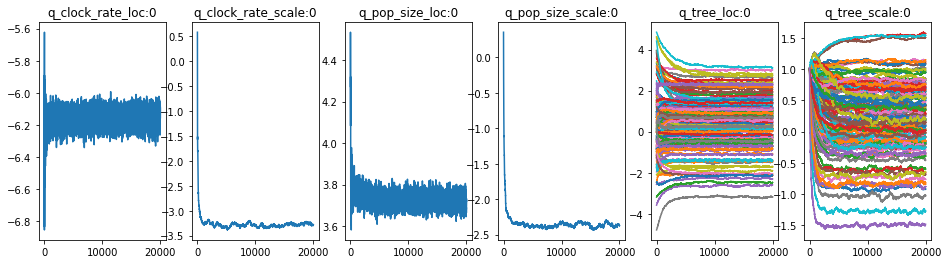

In [16]:
fig, axs = plt.subplots(ncols=len(var_names), figsize=(16, 4))

for ax, vals, name in zip(axs, res[1], var_names):
    ax.plot(vals)
    ax.set_title(name)